In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [3]:
pd.read_csv('sensor9y.csv').head()

,sensor,9y
0,0.039216,235.392
1,0.039216,236.682
2,0.039216,238.002
3,0.039216,237.996
4,0.039216,237.974


In [4]:
train_x = []

# Store csv file in a Pandas DataFrame
df = pd.read_csv('sensor9y.csv')

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:,1].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
# Define lookback period and split inputs/labels
lookback = 8
inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros(len(data)-lookback)

for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i,1]
inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1,1)

In [16]:
# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]

In [21]:
print(train_x.shape)

(441, 8, 2)


In [135]:
batch_size = 10

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [125]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [126]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [127]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the model
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            #if counter%20 == 0:
            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [128]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))
    
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [136]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/44....... Average Loss for Epoch: 0.3376961946487427
Epoch 1......Step: 2/44....... Average Loss for Epoch: 0.26220444589853287
Epoch 1......Step: 3/44....... Average Loss for Epoch: 0.23997630178928375
Epoch 1......Step: 4/44....... Average Loss for Epoch: 0.21106463856995106
Epoch 1......Step: 5/44....... Average Loss for Epoch: 0.1847201555967331
Epoch 1......Step: 6/44....... Average Loss for Epoch: 0.16759456197420755
Epoch 1......Step: 7/44....... Average Loss for Epoch: 0.15703302408967698
Epoch 1......Step: 8/44....... Average Loss for Epoch: 0.1524287350475788
Epoch 1......Step: 9/44....... Average Loss for Epoch: 0.14893464744091034
Epoch 1......Step: 10/44....... Average Loss for Epoch: 0.13940439596772194
Epoch 1......Step: 11/44....... Average Loss for Epoch: 0.13466474278406662
Epoch 1......Step: 12/44....... Average Loss for Epoch: 0.12883031740784645
Epoch 1......Step: 13/44....... Average Loss for Epoch: 0.12531555902

Epoch 3......Step: 17/44....... Average Loss for Epoch: 0.033438658506116443
Epoch 3......Step: 18/44....... Average Loss for Epoch: 0.032919307394574084
Epoch 3......Step: 19/44....... Average Loss for Epoch: 0.031850194313416354
Epoch 3......Step: 20/44....... Average Loss for Epoch: 0.031121415412053467
Epoch 3......Step: 21/44....... Average Loss for Epoch: 0.03025037453820308
Epoch 3......Step: 22/44....... Average Loss for Epoch: 0.029535731851038607
Epoch 3......Step: 23/44....... Average Loss for Epoch: 0.029688391389082306
Epoch 3......Step: 24/44....... Average Loss for Epoch: 0.031548272857132055
Epoch 3......Step: 25/44....... Average Loss for Epoch: 0.03239973235875368
Epoch 3......Step: 26/44....... Average Loss for Epoch: 0.03298665615371787
Epoch 3......Step: 27/44....... Average Loss for Epoch: 0.033819620290564165
Epoch 3......Step: 28/44....... Average Loss for Epoch: 0.03310221869365445
Epoch 3......Step: 29/44....... Average Loss for Epoch: 0.03327671319631667
Epoc

Epoch 5......Step: 40/44....... Average Loss for Epoch: 0.030596666946075858
Epoch 5......Step: 41/44....... Average Loss for Epoch: 0.030699627042361875
Epoch 5......Step: 42/44....... Average Loss for Epoch: 0.03041298104272712
Epoch 5......Step: 43/44....... Average Loss for Epoch: 0.031649806839955406
Epoch 5......Step: 44/44....... Average Loss for Epoch: 0.0316421167967333
Epoch 5/5 Done, Total Loss: 0.0316421167967333
Time Elapsed for Epoch: 0.8076516999999512 seconds
Total Training Time: 4.086060300000099 seconds


In [137]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.016697799999747076
sMAPE: 1.3633677704566585%


In [138]:
print(gru_outputs)

[array([245.84395, 245.73222, 245.6508 , 246.11147, 245.5741 , 246.10052,
       247.6869 , 250.193  , 254.77301, 260.5338 , 268.2759 , 274.4807 ,
       282.0025 , 290.6752 , 297.75284, 277.34012, 286.10934, 300.4563 ,
       321.6285 , 332.489  , 342.21875, 340.8509 , 341.02524, 336.43024,
       330.10623, 326.72916, 278.70374, 290.62387, 309.25247, 319.22714,
       323.97275, 315.46094, 303.1953 , 294.82837, 285.19595, 278.4714 ,
       271.5386 , 252.22325, 251.2919 , 253.21307, 253.63321, 253.80386,
       250.82988, 247.07562, 243.70879, 243.61287, 244.21011, 244.73476],
      dtype=float32)]


In [139]:
print(targets)

[array([239.291, 238.02 , 240.614, 235.374, 241.88 , 245.818, 248.441,
       256.25 , 260.193, 270.614, 271.94 , 283.67 , 292.798, 294.123,
       235.377, 311.06 , 313.645, 342.382, 335.877, 358.034, 346.302,
       359.341, 351.502, 343.708, 347.597, 236.659, 363.274, 346.313,
       334.564, 344.982, 322.788, 311.098, 307.147, 294.101, 282.376,
       274.51 , 235.363, 271.892, 260.171, 252.316, 252.324, 244.512,
       241.884, 236.707, 240.597, 237.995, 237.971, 238.005])]


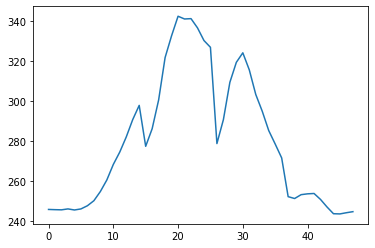

In [140]:
plt.plot(gru_outputs[0])
plt.show()

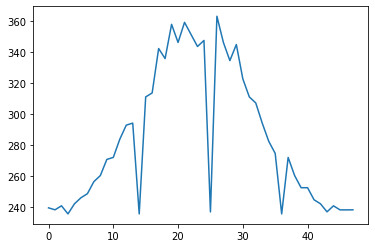

In [141]:
plt.plot(targets[0])
plt.show()